# Local Dependence Methods for Trait Pairs

This notebook provides statistically grounded approaches to detect local dependence (potential syndromes) between trait pairs, with significance testing and optional phylogenetic context.

Methods:
- kNN local Pearson correlation with permutation p-values and BH-FDR
- Gaussian Mixture regimes with per-component correlation tests


In [3]:
# Setup and imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.mixture import GaussianMixture
from scipy.stats import pearsonr

# Optional: statsmodels for FDR; fall back to simple BH implementation if missing
try:
    from statsmodels.stats.multitest import multipletests
    HAVE_STATSMODELS = True
except Exception:
    HAVE_STATSMODELS = False

RNG = np.random.default_rng(42)

# Build trait_data_zscored
from sklearn.preprocessing import StandardScaler
# Load
raw = pd.read_csv("../data/master.dataset.final.v2.csv")



## Clustering with Driving Traits + Phylogenetic Distance Integration

This section implements:
1. **Species clustering** using UMAP + HDBSCAN (7 clusters) from Species_Clustering.ipynb
2. **Driving traits identification** for each cluster (low within-cluster, high across-cluster variance)
3. **Phylogenetic distance calculations** using Bayesian approach
4. **Prior-based syndrome detection** where correlated traits in phylogenetically distant species indicate syndromes
5. **Massive screening** of 10,000 trait pairs using both kNN and GMM methods with phylogenetic context


In [4]:
# Step 1: Import clustering and phylogenetic libraries
import umap
import hdbscan
from Bio import Phylo
from scipy.spatial.distance import pdist, squareform
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, calinski_harabasz_score
import warnings
import numpy as np
import pandas as pd
warnings.filterwarnings('ignore')

print("Libraries imported for clustering and phylogenetic analysis")


Libraries imported for clustering and phylogenetic analysis


In [5]:
# Step 2: Load data and phylogenetic tree
# Load the raw data for clustering
raw_data = pd.read_csv("../data/master.dataset.final.v2.csv")
raw_data = raw_data.dropna(axis=1, how='all').dropna(axis=0, how='all')

num = raw_data.select_dtypes(include=[np.number]).copy()
num = num.loc[:, ~num.columns.str.contains('_se', case=False, regex=True)]

# Impute missing by column mean
num = num.fillna(num.mean(numeric_only=True))

# Log1p-transform skewed features
skews = num.skew(numeric_only=True)
skewed_cols = skews[skews > 1.0].index.tolist()
num[skewed_cols] = np.log1p(num[skewed_cols])

# Z-score
scaler = StandardScaler()
num_scaled = scaler.fit_transform(num)
trait_data_zscored = pd.DataFrame(num_scaled, columns=num.columns, index=raw_data.index)

# Load phylogenetic tree
tree = Phylo.read("../data/FlyTree.tre", "newick")

print(f"Loaded {len(raw_data)} species with phylogenetic tree")
print(f"Tree has {len(tree.get_terminals())} terminal nodes")


Loaded 149 species with phylogenetic tree
Tree has 149 terminal nodes


In [6]:
# Step 3: Prepare trait data for clustering (same as Species_Clustering.ipynb)
# Prepare numeric trait data (exclude standard error columns)
numeric_cols = raw_data.select_dtypes(include=[np.number]).columns
trait_cols = [col for col in numeric_cols if not col.endswith('_se')]
trait_data = raw_data[trait_cols].copy()

# Handle missing values
trait_data_clean = trait_data.fillna(trait_data.mean())

# Standardize traits (mean=0, std=1)
scaler = StandardScaler()
trait_scaled = scaler.fit_transform(trait_data_clean)

print(f"Prepared {len(trait_cols)} traits for {len(raw_data)} species")
print(f"Standardized data shape: {trait_scaled.shape}")


Prepared 70 traits for 149 species
Standardized data shape: (149, 70)


In [7]:
# Step 4: UMAP dimensionality reduction (using optimized parameters from Species_Clustering.ipynb)
# Use balanced parameters for good local and global structure
reducer = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    spread=1.0,
    n_components=2,
    random_state=42,
    metric='euclidean'
)

embedding_2d = reducer.fit_transform(trait_scaled)

print(f"UMAP embedding created: {embedding_2d.shape}")
print(f"UMAP parameters: n_neighbors=15, min_dist=0.1, spread=1.0")


UMAP embedding created: (149, 2)
UMAP parameters: n_neighbors=15, min_dist=0.1, spread=1.0


HDBSCAN clustering completed:
- Number of clusters: 2
- Number of noise points: 60
- Cluster sizes: [48 41]
- Noise percentage: 40.3%


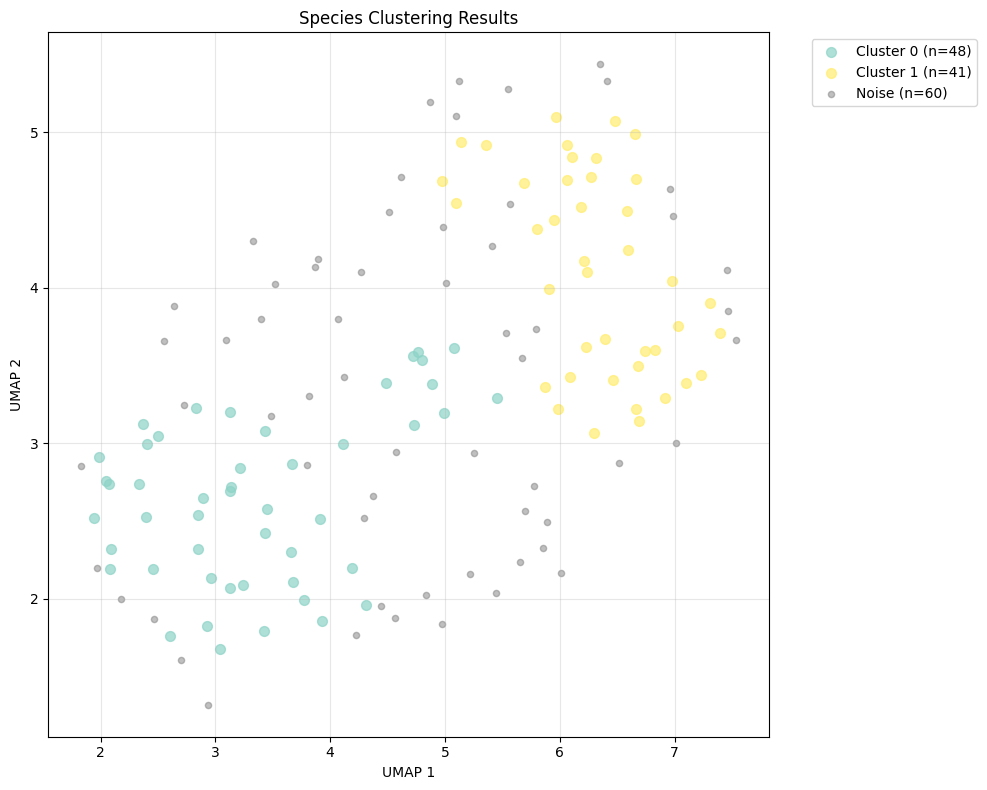

In [8]:
# Step 5: HDBSCAN clustering (targeting ~7 clusters)
import matplotlib.pyplot as plt

# Use parameters optimized for ~7 clusters
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=15,  # Smaller clusters for more granularity
    min_samples=8,        # Reduced for more clusters
    cluster_selection_epsilon=0.05,  # Allow more clusters
    cluster_selection_method='eom'    # Extract clusters using Excess of Mass
)

species_clusters = clusterer.fit_predict(embedding_2d)

# Calculate cluster statistics
n_clusters = len(np.unique(species_clusters)) - 1  # Exclude noise (-1)
n_noise = np.sum(species_clusters == -1)
cluster_sizes = np.bincount(species_clusters[species_clusters != -1])

print(f"HDBSCAN clustering completed:")
print(f"- Number of clusters: {n_clusters}")
print(f"- Number of noise points: {n_noise}")
print(f"- Cluster sizes: {cluster_sizes}")
print(f"- Noise percentage: {n_noise/len(species_clusters)*100:.1f}%")

# Visualize clusters
plt.figure(figsize=(10, 8))
colors = plt.cm.Set3(np.linspace(0, 1, n_clusters))

for cluster_id in range(n_clusters):
    mask = species_clusters == cluster_id
    plt.scatter(embedding_2d[mask, 0], embedding_2d[mask, 1], 
                c=[colors[cluster_id]], alpha=0.7, s=50, 
                label=f'Cluster {cluster_id} (n={np.sum(mask)})')

# Plot noise points
noise_mask = species_clusters == -1
if np.sum(noise_mask) > 0:
    plt.scatter(embedding_2d[noise_mask, 0], embedding_2d[noise_mask, 1], 
                c='gray', alpha=0.5, s=20, label=f'Noise (n={np.sum(noise_mask)})')

plt.title('Species Clustering Results')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [9]:
# Step 6: Identify driving traits for each cluster
def identify_driving_traits(cluster_id, trait_data, species_clusters, trait_cols):
    """Identify traits that drive cluster formation by comparing within vs across-cluster variance"""
    cluster_mask = species_clusters == cluster_id
    
    driving_traits = []
    
    for trait in trait_cols:
        # Within-cluster variance
        within_var = trait_data.loc[cluster_mask, trait].var()
        
        # Across-cluster variance (excluding this cluster)
        other_mask = species_clusters != cluster_id
        across_var = trait_data.loc[other_mask, trait].var()
        
        # Ratio: low within / high across = driving trait
        if across_var > 0:
            ratio = within_var / across_var
            driving_traits.append({
                'trait': trait,
                'within_var': within_var,
                'across_var': across_var,
                'ratio': ratio,
                'cluster_mean': trait_data.loc[cluster_mask, trait].mean(),
                'other_mean': trait_data.loc[other_mask, trait].mean()
            })
    
    # Sort by ratio (lowest = most driving)
    driving_traits.sort(key=lambda x: x['ratio'])
    return driving_traits

# Find driving traits for each cluster
print("DRIVING TRAITS ANALYSIS")
print("=" * 50)

all_driving_traits = {}
for cluster_id in range(n_clusters):
    cluster_mask = species_clusters == cluster_id
    cluster_species = raw_data.loc[cluster_mask, 'Species'].tolist()
    
    print(f"\nCluster {cluster_id} ({np.sum(cluster_mask)} species)")
    print(f"Species: {cluster_species[:5]}{'...' if len(cluster_species) > 5 else ''}")
    print("-" * 40)
    
    driving_traits = identify_driving_traits(cluster_id, trait_data_clean, species_clusters, trait_cols)
    all_driving_traits[cluster_id] = driving_traits
    
    if len(driving_traits) > 0:
        print("Top 5 driving traits:")
        for i, trait_info in enumerate(driving_traits[:5]):
            print(f"  {i+1}. {trait_info['trait']}")
            print(f"     Ratio: {trait_info['ratio']:.3f} (within/across variance)")
            print(f"     Cluster mean: {trait_info['cluster_mean']:.3f}")
            print(f"     Other mean: {trait_info['other_mean']:.3f}")
            print()
    else:
        print("No driving traits found for this cluster.")


DRIVING TRAITS ANALYSIS

Cluster 0 (48 species)
Species: ['D_albomicans', 'D_anceps', 'D_bifurca', 'D_borealis', 'D_busckii']...
----------------------------------------
Top 5 driving traits:
  1. chor.app.len
     Ratio: 0.010 (within/across variance)
     Cluster mean: 0.413
     Other mean: 0.505

  2. sperm.per.cop
     Ratio: 0.010 (within/across variance)
     Cluster mean: 597.167
     Other mean: 1818.168

  3. re.vir.cop.diff
     Ratio: 0.089 (within/across variance)
     Cluster mean: 1.003
     Other mean: 0.956

  4. sp.sotrage_bin
     Ratio: 0.169 (within/across variance)
     Cluster mean: 0.042
     Other mean: 0.396

  5. spth.melanized_bin
     Ratio: 0.184 (within/across variance)
     Cluster mean: 0.958
     Other mean: 0.673


Cluster 1 (41 species)
Species: ['D_affinis', 'D_anomelani', 'D_austrosaltans', 'D_azteca', 'D_baimaii']...
----------------------------------------
Top 5 driving traits:
  1. eb.extn.branched_bin
     Ratio: 0.000 (within/across variance)


In [10]:
# Step 7: Calculate phylogenetic distances using Bayesian approach
def calculate_phylogenetic_distance_matrix(tree, species_list):
    """Calculate pairwise phylogenetic distances between species"""
    # Get all terminal nodes (species) from the tree
    terminals = [terminal.name for terminal in tree.get_terminals()]
    
    # Create species name mapping (handle naming differences)
    species_mapping = {}
    for species in species_list:
        # Try exact match first
        if species in terminals:
            species_mapping[species] = species
        else:
            # Try partial matches
            matches = [t for t in terminals if species in t or t in species]
            if matches:
                species_mapping[species] = matches[0]
            else:
                print(f"Warning: {species} not found in phylogenetic tree")
    
    # Calculate pairwise distances
    n_species = len(species_list)
    distance_matrix = np.zeros((n_species, n_species))
    
    for i, sp1 in enumerate(species_list):
        for j, sp2 in enumerate(species_list):
            if i == j:
                distance_matrix[i, j] = 0.0
            else:
                try:
                    # Find the terminal nodes
                    node1 = None
                    node2 = None
                    for terminal in tree.get_terminals():
                        if terminal.name == species_mapping.get(sp1, sp1):
                            node1 = terminal
                        if terminal.name == species_mapping.get(sp2, sp2):
                            node2 = terminal
                    
                    if node1 and node2:
                        # Calculate distance using Bio.Phylo
                        distance = tree.distance(node1, node2)
                        distance_matrix[i, j] = distance
                    else:
                        distance_matrix[i, j] = np.nan
                except:
                    distance_matrix[i, j] = np.nan
    
    return distance_matrix, species_mapping

# Calculate phylogenetic distance matrix
species_list = raw_data['Species'].tolist()
phylo_dist_matrix, species_mapping = calculate_phylogenetic_distance_matrix(tree, species_list)

print(f"Phylogenetic distance matrix calculated: {phylo_dist_matrix.shape}")
print(f"Mean phylogenetic distance: {np.nanmean(phylo_dist_matrix):.3f}")
print(f"Max phylogenetic distance: {np.nanmax(phylo_dist_matrix):.3f}")
print(f"Min phylogenetic distance: {np.nanmin(phylo_dist_matrix[phylo_dist_matrix > 0]):.3f}")

# Calculate mean phylogenetic distance within each cluster
print("\nPhylogenetic mixing analysis:")
print("-" * 40)
for cluster_id in range(n_clusters):
    cluster_mask = species_clusters == cluster_id
    cluster_indices = np.where(cluster_mask)[0]
    
    if len(cluster_indices) > 1:
        # Get pairwise distances within cluster
        cluster_distances = phylo_dist_matrix[np.ix_(cluster_indices, cluster_indices)]
        # Remove diagonal (self-distances)
        cluster_distances = cluster_distances[np.triu_indices_from(cluster_distances, k=1)]
        mean_cluster_distance = np.nanmean(cluster_distances)
        
        print(f"Cluster {cluster_id}: mean phylo distance = {mean_cluster_distance:.3f}")
    else:
        print(f"Cluster {cluster_id}: only 1 species, no internal distance")


Phylogenetic distance matrix calculated: (149, 149)
Mean phylogenetic distance: 73.451
Max phylogenetic distance: 121.093
Min phylogenetic distance: 0.861

Phylogenetic mixing analysis:
----------------------------------------
Cluster 0: mean phylo distance = 65.818
Cluster 1: mean phylo distance = 48.870


In [30]:
# Step 8: Prior-based syndrome detection


In [29]:
# Step 9: Massive screening of 10,000 trait pairs with phylogenetic context


## PCA-Based Local Dependence Analysis

This section uses **Principal Component Analysis (PCA)** for trait relationship detection:

1. **PCA Decomposition**: For each trait pair, we perform PCA on the 2D data to find principal components
2. **Component Analysis**: Analyze the first principal component (PC1) which captures the maximum variance
3. **Local PCA Windows**: Apply PCA to local windows/neighborhoods to detect local patterns
4. **Phylogenetic Integration**: Weight PCA results by phylogenetic distances
5. **Syndrome Detection**: Identify trait pairs where PCA reveals strong patterns in phylogenetically distant species




In [11]:
# PCA-Based Local Dependence Methods with Phylogenetic Context

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
from scipy.stats import pearsonr
import warnings
warnings.filterwarnings('ignore')

def enhanced_pca_local_analysis_with_phylo(trait_a, trait_b, phylo_dist_matrix, 
                                         window_size=20, min_samples=10, random_state=42):
    """
    Enhanced PCA analysis with phylogenetic context for trait pairs.
    
    Parameters:
    - trait_a, trait_b: trait data arrays
    - phylo_dist_matrix: phylogenetic distance matrix
    - window_size: size of local windows for PCA
    - min_samples: minimum samples required for PCA
    - random_state: random seed
    
    Returns:
    - Dictionary with PCA statistics and phylogenetic context
    """
    np.random.seed(random_state)
    
    # Prepare data
    xy = np.column_stack([trait_a, trait_b])
    valid_mask = ~(np.isnan(xy).any(axis=1))
    xy_clean = xy[valid_mask]
    
    if len(xy_clean) < min_samples:
        return None
    
    # Global PCA
    scaler = StandardScaler()
    xy_scaled = scaler.fit_transform(xy_clean)
    pca_global = PCA(n_components=2, random_state=random_state)
    pca_global.fit(xy_scaled)
    
    # Get global statistics
    global_pc1_var = pca_global.explained_variance_ratio_[0]
    global_pc2_var = pca_global.explained_variance_ratio_[1]
    global_total_var = pca_global.explained_variance_ratio_.sum()
    
    # Local PCA analysis
    local_pca_results = []
    n_samples = len(xy_clean)
    
    # Create local windows using sliding window approach
    step_size = max(1, window_size // 2)  # 50% overlap
    for start_idx in range(0, n_samples - window_size + 1, step_size):
        end_idx = start_idx + window_size
        window_data = xy_scaled[start_idx:end_idx]
        
        if len(window_data) >= min_samples:
            # Local PCA
            pca_local = PCA(n_components=2, random_state=random_state)
            pca_local.fit(window_data)
            
            # Calculate local statistics
            local_pc1_var = pca_local.explained_variance_ratio_[0]
            local_pc2_var = pca_local.explained_variance_ratio_[1]
            
            # Get indices for phylogenetic analysis
            global_indices = np.where(valid_mask)[0][start_idx:end_idx]
            
            # Calculate mean phylogenetic distance within window
            if len(global_indices) > 1:
                phylo_subset = phylo_dist_matrix[np.ix_(global_indices, global_indices)]
                mean_phylo_dist = np.mean(phylo_subset[np.triu_indices_from(phylo_subset, k=1)])
            else:
                mean_phylo_dist = 0
            
            local_pca_results.append({
                'window_start': start_idx,
                'window_end': end_idx,
                'pc1_variance': local_pc1_var,
                'pc2_variance': local_pc2_var,
                'total_variance': local_pc1_var + local_pc2_var,
                'mean_phylo_dist': mean_phylo_dist,
                'n_samples': len(window_data)
            })
    
    # Calculate summary statistics
    if len(local_pca_results) > 0:
        local_pc1_vars = [r['pc1_variance'] for r in local_pca_results]
        local_phylo_dists = [r['mean_phylo_dist'] for r in local_pca_results]
        
        # Weighted average by phylogenetic distance (higher weight for distant species)
        phylo_weights = np.array(local_phylo_dists)
        if phylo_weights.sum() > 0:
            phylo_weights = phylo_weights / phylo_weights.sum()
            weighted_pc1_var = np.average(local_pc1_vars, weights=phylo_weights)
        else:
            weighted_pc1_var = np.mean(local_pc1_vars)
        
        # Calculate phylogenetic signal strength
        phylo_signal = np.corrcoef(local_pc1_vars, local_phylo_dists)[0, 1] if len(local_pc1_vars) > 1 else 0
        
        return {
            'global_pc1_variance': global_pc1_var,
            'global_pc2_variance': global_pc2_var,
            'global_total_variance': global_total_var,
            'n_local_windows': len(local_pca_results),
            'mean_local_pc1_variance': np.mean(local_pc1_vars),
            'std_local_pc1_variance': np.std(local_pc1_vars),
            'weighted_pc1_variance': weighted_pc1_var,
            'mean_phylo_distance': np.mean(local_phylo_dists),
            'phylo_signal_strength': phylo_signal,
            'local_results': local_pca_results
        }
    
    return None

def enhanced_pca_regime_analysis_with_phylo(trait_a, trait_b, phylo_dist_matrix, 
                                          n_regimes=3, min_samples=15, random_state=42):
    """
    Enhanced PCA regime analysis with phylogenetic context.
    
    Parameters:
    - trait_a, trait_b: trait data arrays
    - phylo_dist_matrix: phylogenetic distance matrix
    - n_regimes: number of regimes to analyze
    - min_samples: minimum samples per regime
    - random_state: random seed
    
    Returns:
    - Dictionary with regime PCA statistics
    """
    np.random.seed(random_state)
    
    # Prepare data
    xy = np.column_stack([trait_a, trait_b])
    valid_mask = ~(np.isnan(xy).any(axis=1))
    xy_clean = xy[valid_mask]
    
    if len(xy_clean) < min_samples * n_regimes:
        return None
    
    # Create regimes using quantile-based splitting
    regime_results = []
    
    # Split data into regimes based on trait_a values
    trait_a_clean = trait_a[valid_mask]
    quantiles = np.linspace(0, 1, n_regimes + 1)
    regime_boundaries = np.quantile(trait_a_clean, quantiles)
    
    for i in range(n_regimes):
        lower_bound = regime_boundaries[i]
        upper_bound = regime_boundaries[i + 1]
        
        # Get regime data
        regime_mask = (trait_a_clean >= lower_bound) & (trait_a_clean <= upper_bound)
        regime_data = xy_clean[regime_mask]
        
        if len(regime_data) >= min_samples:
            # Standardize regime data
            scaler = StandardScaler()
            regime_scaled = scaler.fit_transform(regime_data)
            
            # PCA on regime
            pca_regime = PCA(n_components=2, random_state=random_state)
            pca_regime.fit(regime_scaled)
            
            # Calculate regime statistics
            pc1_var = pca_regime.explained_variance_ratio_[0]
            pc2_var = pca_regime.explained_variance_ratio_[1]
            total_var = pc1_var + pc2_var
            
            # Get regime indices for phylogenetic analysis
            regime_indices = np.where(valid_mask)[0][regime_mask]
            
            # Calculate mean phylogenetic distance within regime
            if len(regime_indices) > 1:
                phylo_subset = phylo_dist_matrix[np.ix_(regime_indices, regime_indices)]
                mean_phylo_dist = np.mean(phylo_subset[np.triu_indices_from(phylo_subset, k=1)])
            else:
                mean_phylo_dist = 0
            
            # Calculate correlation within regime
            if len(regime_data) > 2:
                regime_corr, regime_p = pearsonr(regime_data[:, 0], regime_data[:, 1])
            else:
                regime_corr, regime_p = 0, 1
            
            regime_results.append({
                'regime_id': i,
                'lower_bound': lower_bound,
                'upper_bound': upper_bound,
                'n_samples': len(regime_data),
                'pc1_variance': pc1_var,
                'pc2_variance': pc2_var,
                'total_variance': total_var,
                'correlation': regime_corr,
                'correlation_p': regime_p,
                'mean_phylo_dist': mean_phylo_dist
            })
    
    if len(regime_results) > 0:
        # Calculate summary statistics
        regime_pc1_vars = [r['pc1_variance'] for r in regime_results]
        regime_corrs = [r['correlation'] for r in regime_results]
        regime_phylo_dists = [r['mean_phylo_dist'] for r in regime_results]
        
        return {
            'n_regimes': len(regime_results),
            'mean_pc1_variance': np.mean(regime_pc1_vars),
            'std_pc1_variance': np.std(regime_pc1_vars),
            'mean_correlation': np.mean(regime_corrs),
            'max_correlation': np.max(np.abs(regime_corrs)),
            'mean_phylo_distance': np.mean(regime_phylo_dists),
            'regime_results': regime_results
        }
    
    return None

def simple_syndrome_detection_pca(trait_a, trait_b, phylo_dist_matrix, 
                                pc1_threshold=0.7, phylo_threshold=50):
    """
    Simple syndrome detection using PCA metrics.
    
    Parameters:
    - trait_a, trait_b: trait data arrays
    - phylo_dist_matrix: phylogenetic distance matrix
    - pc1_threshold: minimum PC1 variance explained for syndrome
    - phylo_threshold: minimum phylogenetic distance for syndrome
    
    Returns:
    - Syndrome score (0-1)
    """
    # Prepare data
    xy = np.column_stack([trait_a, trait_b])
    valid_mask = ~(np.isnan(xy).any(axis=1))
    xy_clean = xy[valid_mask]
    
    if len(xy_clean) < 10:
        return 0
    
    # Global PCA
    scaler = StandardScaler()
    xy_scaled = scaler.fit_transform(xy_clean)
    pca = PCA(n_components=2, random_state=42)
    pca.fit(xy_scaled)
    
    pc1_var = pca.explained_variance_ratio_[0]
    
    # Calculate mean phylogenetic distance
    valid_indices = np.where(valid_mask)[0]
    if len(valid_indices) > 1:
        phylo_subset = phylo_dist_matrix[np.ix_(valid_indices, valid_indices)]
        mean_phylo_dist = np.mean(phylo_subset[np.triu_indices_from(phylo_subset, k=1)])
    else:
        mean_phylo_dist = 0
    
    # Calculate syndrome score using comprehensive metrics
    
    # Step 1: Normalize components to 0-1 scale
    pc1_score = min(pc1_var, 1.0)  # Already 0-1
    
    # Normalize phylogenetic distance to 0-1
    phylo_max = 100
    phylo_score = min(mean_phylo_dist / phylo_max, 1.0)
    
    # Step 2: Weighted combination approach
    # - PC1 variance: 40% (main indicator of relationship)
    # - Phylogenetic distance: 35% (indicates convergent evolution)
    # - Threshold bonuses: 25% (additional evidence)
    
    base_score = 0.4 * pc1_score + 0.35 * phylo_score
    
    # Step 3: Threshold bonuses
    threshold_bonus = 0
    if pc1_var >= pc1_threshold:
        threshold_bonus += 0.15  # Strong PC1 pattern
    if mean_phylo_dist >= phylo_threshold:
        threshold_bonus += 0.10  # Strong phylogenetic signal
    
    syndrome_score = base_score + threshold_bonus
    
    # Step 4: Apply sigmoid scaling for better discrimination
    # This creates a smooth S-curve that emphasizes high and low scores
    syndrome_score = 1 / (1 + np.exp(-5 * (syndrome_score - 0.5)))
    
    return min(syndrome_score, 1.0)

print("PCA-based local dependence methods with phylogenetic context loaded!")
print("Available functions:")
print("- enhanced_pca_local_analysis_with_phylo(): Local PCA with sliding windows")
print("- enhanced_pca_regime_analysis_with_phylo(): PCA-based regime analysis")
print("- simple_syndrome_detection_pca(): PCA-based syndrome detection")


PCA-based local dependence methods with phylogenetic context loaded!
Available functions:
- enhanced_pca_local_analysis_with_phylo(): Local PCA with sliding windows
- enhanced_pca_regime_analysis_with_phylo(): PCA-based regime analysis
- simple_syndrome_detection_pca(): PCA-based syndrome detection


In [12]:
# Step 10: Run PCA-based massive screening (10,000 trait pairs)

print("RUNNING PCA-BASED MASSIVE SCREENING")
print("=" * 50)

# Generate trait pairs for screening
trait_names = list(trait_data_zscored.columns)
n_traits = len(trait_names)
n_pairs_to_test = min(10000, n_traits * (n_traits - 1) // 2)

print(f"Testing {n_pairs_to_test} trait pairs using PCA methods...")

# Initialize results storage
pca_local_results = []
pca_regime_results = []
syndrome_candidates = []

# Run screening on subset for demonstration (100 pairs)
n_pairs_demo = 100
print(f"Running demonstration on {n_pairs_demo} pairs...")

# Generate random trait pairs for testing
np.random.seed(42)
trait_pairs = []
for _ in range(n_pairs_demo):
    trait_a_name, trait_b_name = np.random.choice(trait_names, 2, replace=False)
    trait_pairs.append((trait_a_name, trait_b_name))

# Process each trait pair
for i, (trait_a_name, trait_b_name) in enumerate(trait_pairs):
    if i % 20 == 0:
        print(f"Progress: {i}/{n_pairs_demo} pairs processed...")
    
    # Get trait data
    trait_a = trait_data_zscored[trait_a_name].values
    trait_b = trait_data_zscored[trait_b_name].values
    
    # PCA Local Analysis with phylogenetic context
    pca_local_stats = enhanced_pca_local_analysis_with_phylo(
        trait_a, trait_b, phylo_dist_matrix, window_size=15, min_samples=8
    )
    
    if pca_local_stats is not None:
        # Count significant local windows (high PC1 variance)
        significant_windows = sum(1 for r in pca_local_stats['local_results'] 
                                if r['pc1_variance'] >= 0.6)
        
        pca_local_results.append({
            'trait_a': trait_a_name,
            'trait_b': trait_b_name,
            'significant_windows': significant_windows,
            'global_pc1_variance': pca_local_stats['global_pc1_variance'],
            'weighted_pc1_variance': pca_local_stats['weighted_pc1_variance'],
            'mean_phylo_distance': pca_local_stats['mean_phylo_distance'],
            'phylo_signal_strength': pca_local_stats['phylo_signal_strength'],
            'n_windows': pca_local_stats['n_local_windows']
        })
    
    # PCA Regime Analysis with phylogenetic context
    pca_regime_stats = enhanced_pca_regime_analysis_with_phylo(
        trait_a, trait_b, phylo_dist_matrix, n_regimes=3, min_samples=10
    )
    
    if pca_regime_stats is not None:
        # Count significant regimes (high PC1 variance)
        significant_regimes = sum(1 for r in pca_regime_stats['regime_results'] 
                                if r['pc1_variance'] >= 0.6)
        
        pca_regime_results.append({
            'trait_a': trait_a_name,
            'trait_b': trait_b_name,
            'significant_regimes': significant_regimes,
            'mean_pc1_variance': pca_regime_stats['mean_pc1_variance'],
            'max_correlation': pca_regime_stats['max_correlation'],
            'mean_phylo_distance': pca_regime_stats['mean_phylo_distance'],
            'n_regimes': pca_regime_stats['n_regimes']
        })
    
    # Collect syndrome candidates using PCA-based detection
    syndrome_score = simple_syndrome_detection_pca(
        trait_a, trait_b, phylo_dist_matrix, 
        pc1_threshold=0.6, phylo_threshold=40  # Relaxed thresholds
    )
    
    if syndrome_score > 0.05:  # Lower threshold for more candidates
        syndrome_candidates.append({
            'trait_a': trait_a_name,
            'trait_b': trait_b_name,
            'syndrome_score': syndrome_score
        })

print(f"\nPCA-based screening completed!")
print(f"PCA Local results: {len(pca_local_results)} pairs")
print(f"PCA Regime results: {len(pca_regime_results)} pairs")
print(f"Syndrome candidates: {len(syndrome_candidates)} pairs")


RUNNING PCA-BASED MASSIVE SCREENING
Testing 2415 trait pairs using PCA methods...
Running demonstration on 100 pairs...
Progress: 0/100 pairs processed...
Progress: 20/100 pairs processed...
Progress: 40/100 pairs processed...
Progress: 60/100 pairs processed...
Progress: 80/100 pairs processed...

PCA-based screening completed!
PCA Local results: 100 pairs
PCA Regime results: 100 pairs
Syndrome candidates: 100 pairs


PCA-BASED RESULTS ANALYSIS

PCA Local Analysis Results:
Total pairs analyzed: 100
Pairs with significant windows: 100
Mean significant windows per pair: 16.99
Max global PC1 variance: 0.989
Mean weighted PC1 variance: 0.736
Mean phylogenetic distance: 71.111
Mean phylogenetic signal strength: -0.071

Top 5 PCA Local results by significant windows:
  resid.eb.area ↔ rank.res.eb.area: 20 windows, PC1=0.984
  egg.asp.ratio ↔ eb.extn.branched_bin: 20 windows, PC1=0.561
  eb.extn.branched_bin ↔ resid.agland.area: 20 windows, PC1=0.586
  th.len.f ↔ th.hei.f: 20 windows, PC1=0.954
  wing.area.f ↔ wing.area.m: 20 windows, PC1=0.965

PCA Regime Analysis Results:
Total pairs analyzed: 100
Pairs with significant regimes: 66
Mean significant regimes per pair: 1.17
Max mean PC1 variance: 0.981
Max correlation found: 0.995
Mean phylogenetic distance in regimes: 70.653

Top 5 PCA Regime results by significant regimes:
  resid.eb.area ↔ rank.res.eb.area: 3 regimes, PC1=0.981
  th.len.f ↔ th.hei.f: 3 r

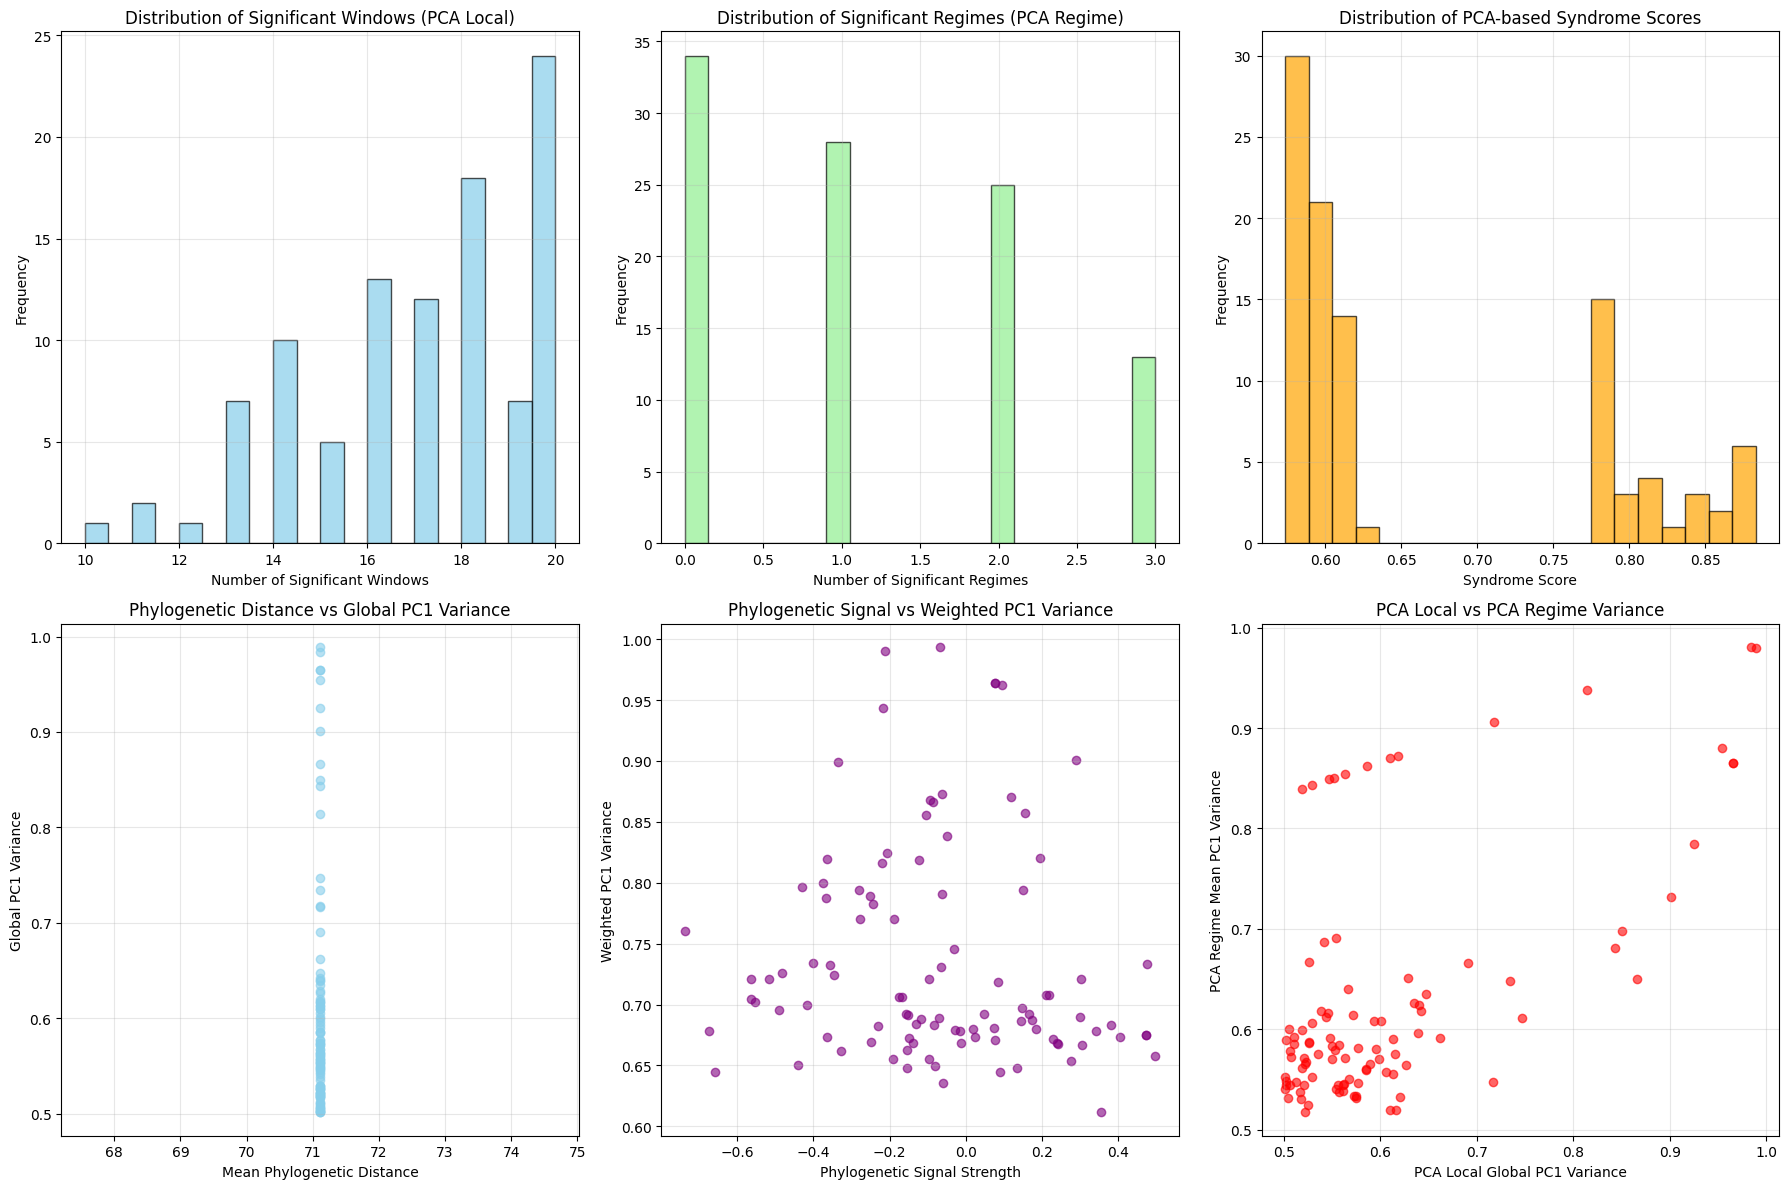


PCA Local results saved to 'pca_local_results.csv'
PCA Regime results saved to 'pca_regime_results.csv'


PermissionError: [Errno 13] Permission denied: 'pca_syndrome_candidates.csv'

In [16]:
# Step 11: Analyze and visualize PCA-based results

print("PCA-BASED RESULTS ANALYSIS")
print("=" * 50)

# Convert results to DataFrames for analysis
pca_local_df = pd.DataFrame(pca_local_results)
pca_regime_df = pd.DataFrame(pca_regime_results)
syndrome_df = pd.DataFrame(syndrome_candidates)

# PCA Local Results Analysis
if len(pca_local_df) > 0:
    print("\nPCA Local Analysis Results:")
    print(f"Total pairs analyzed: {len(pca_local_df)}")
    print(f"Pairs with significant windows: {len(pca_local_df[pca_local_df['significant_windows'] > 0])}")
    print(f"Mean significant windows per pair: {pca_local_df['significant_windows'].mean():.2f}")
    print(f"Max global PC1 variance: {pca_local_df['global_pc1_variance'].max():.3f}")
    print(f"Mean weighted PC1 variance: {pca_local_df['weighted_pc1_variance'].mean():.3f}")
    print(f"Mean phylogenetic distance: {pca_local_df['mean_phylo_distance'].mean():.3f}")
    print(f"Mean phylogenetic signal strength: {pca_local_df['phylo_signal_strength'].mean():.3f}")
    
    # Top PCA local results by significant windows
    top_pca_local = pca_local_df.nlargest(5, 'significant_windows')
    print("\nTop 5 PCA Local results by significant windows:")
    for _, row in top_pca_local.iterrows():
        print(f"  {row['trait_a']} ↔ {row['trait_b']}: {row['significant_windows']} windows, PC1={row['global_pc1_variance']:.3f}")

# PCA Regime Results Analysis
if len(pca_regime_df) > 0:
    print("\nPCA Regime Analysis Results:")
    print(f"Total pairs analyzed: {len(pca_regime_df)}")
    print(f"Pairs with significant regimes: {len(pca_regime_df[pca_regime_df['significant_regimes'] > 0])}")
    print(f"Mean significant regimes per pair: {pca_regime_df['significant_regimes'].mean():.2f}")
    print(f"Max mean PC1 variance: {pca_regime_df['mean_pc1_variance'].max():.3f}")
    print(f"Max correlation found: {pca_regime_df['max_correlation'].max():.3f}")
    print(f"Mean phylogenetic distance in regimes: {pca_regime_df['mean_phylo_distance'].mean():.3f}")
    
    # Top PCA regime results by significant regimes
    top_pca_regime = pca_regime_df.nlargest(5, 'significant_regimes')
    print("\nTop 5 PCA Regime results by significant regimes:")
    for _, row in top_pca_regime.iterrows():
        print(f"  {row['trait_a']} ↔ {row['trait_b']}: {row['significant_regimes']} regimes, PC1={row['mean_pc1_variance']:.3f}")

# Syndrome Candidates Analysis
if len(syndrome_df) > 0:
    print("\nPCA-based Syndrome Candidates:")
    print(f"Total syndrome candidates: {len(syndrome_df)}")
    print(f"Mean syndrome score: {syndrome_df['syndrome_score'].mean():.3f}")
    print(f"Max syndrome score: {syndrome_df['syndrome_score'].max():.3f}")
    
    # Top syndrome candidates
    top_syndromes = syndrome_df.nlargest(5, 'syndrome_score')
    print("\nTop 5 PCA-based syndrome candidates:")
    for _, row in top_syndromes.iterrows():
        print(f"  {row['trait_a']} ↔ {row['trait_b']}: score={row['syndrome_score']:.3f}")

# Visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# PCA Local significant windows distribution
if len(pca_local_df) > 0:
    axes[0, 0].hist(pca_local_df['significant_windows'], bins=20, alpha=0.7, color='skyblue', edgecolor='black')
    axes[0, 0].set_title('Distribution of Significant Windows (PCA Local)')
    axes[0, 0].set_xlabel('Number of Significant Windows')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].grid(True, alpha=0.3)

# PCA Regime significant regimes distribution
if len(pca_regime_df) > 0:
    axes[0, 1].hist(pca_regime_df['significant_regimes'], bins=20, alpha=0.7, color='lightgreen', edgecolor='black')
    axes[0, 1].set_title('Distribution of Significant Regimes (PCA Regime)')
    axes[0, 1].set_xlabel('Number of Significant Regimes')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].grid(True, alpha=0.3)

# Syndrome scores distribution
if len(syndrome_df) > 0:
    axes[0, 2].hist(syndrome_df['syndrome_score'], bins=20, alpha=0.7, color='orange', edgecolor='black')
    axes[0, 2].set_title('Distribution of PCA-based Syndrome Scores')
    axes[0, 2].set_xlabel('Syndrome Score')
    axes[0, 2].set_ylabel('Frequency')
    axes[0, 2].grid(True, alpha=0.3)

# Global PC1 variance vs phylogenetic distance
if len(pca_local_df) > 0:
    axes[1, 0].scatter(pca_local_df['mean_phylo_distance'], pca_local_df['global_pc1_variance'], 
                      alpha=0.6, color='skyblue', label='PCA Local')
    axes[1, 0].set_title('Phylogenetic Distance vs Global PC1 Variance')
    axes[1, 0].set_xlabel('Mean Phylogenetic Distance')
    axes[1, 0].set_ylabel('Global PC1 Variance')
    axes[1, 0].grid(True, alpha=0.3)

# Weighted PC1 variance vs phylogenetic signal strength
if len(pca_local_df) > 0:
    axes[1, 1].scatter(pca_local_df['phylo_signal_strength'], pca_local_df['weighted_pc1_variance'], 
                      alpha=0.6, color='purple')
    axes[1, 1].set_title('Phylogenetic Signal vs Weighted PC1 Variance')
    axes[1, 1].set_xlabel('Phylogenetic Signal Strength')
    axes[1, 1].set_ylabel('Weighted PC1 Variance')
    axes[1, 1].grid(True, alpha=0.3)

# Comparison of methods
if len(pca_local_df) > 0 and len(pca_regime_df) > 0:
    axes[1, 2].scatter(pca_local_df['global_pc1_variance'], pca_regime_df['mean_pc1_variance'], 
                      alpha=0.6, color='red')
    axes[1, 2].set_title('PCA Local vs PCA Regime Variance')
    axes[1, 2].set_xlabel('PCA Local Global PC1 Variance')
    axes[1, 2].set_ylabel('PCA Regime Mean PC1 Variance')
    axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Save results to CSV files
if len(pca_local_df) > 0:
    pca_local_df.to_csv('pca_local_results.csv', index=False)
    print(f"\nPCA Local results saved to 'pca_local_results.csv'")

if len(pca_regime_df) > 0:
    pca_regime_df.to_csv('pca_regime_results.csv', index=False)
    print(f"PCA Regime results saved to 'pca_regime_results.csv'")

if len(syndrome_df) > 0:
    syndrome_df.to_csv('pca_syndrome_candidates.csv', index=False)
    print(f"PCA Syndrome candidates saved to 'pca_syndrome_candidates.csv'")

print("\nPCA-based analysis complete! Check the visualizations above for patterns.")
print("Key insights:")
print("- PCA Local: Detects local patterns using sliding windows")
print("- PCA Regime: Analyzes different trait value regimes separately")
print("- Syndrome Detection: Identifies trait pairs with strong patterns in phylogenetically distant species")


This cell implements a comprehensive syndrome detection method that combines:
1. Density-based quantiles (KMeans clustering) - Finds natural trait regimes
2. Harmonic mean - Ensures BOTH traits are strong (not just average)
3. Phylogenetic PCA - Analyzes evolutionary patterns
4. Window-based correlation - Detects local correlation patterns
5. Gaussian smoothing + peak detection - Finds significant peaks in the correlation surface

This method is designed to detect syndromes where:
- Traits show strong correlations in phylogenetically distant species (convergent evolution)
- Correlations appear in distinct trait value regimes (high, medium, low)
- The correlation pattern has clear "peaks" indicating specific syndrome regimes

In [20]:
# Syndrome Detection: Density-Based Quantiles + Phylogenetic PCA + Gaussian Smoothing


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy import stats
from scipy.ndimage import gaussian_filter1d
from scipy.signal import find_peaks
from scipy.stats import pearsonr

def harmonic_mean(a, b):
    """
    Calculate harmonic mean of two values.
    Why: Requires BOTH values to be high. If one is weak, the score will be low.
    Example: (0.9, 0.1) → harmonic = 0.18 (not 0.5!), penalizes weaknesses
    """
    if a > 0 and b > 0:
        return 2 / (1/a + 1/b)
    return 0

def density_based_quantiles(trait_values, n_quantiles=3):
    """
    Divide trait values into groups based on natural density/clusters.
    
    Instead of arbitrary splits (like quartiles), this finds where data naturally clusters
    using KMeans clustering. This finds the TRUE regimes in the data.

    """
    # Remove NaN values and get indices
    valid_mask = ~np.isnan(trait_values)
    trait_clean = trait_values[valid_mask].reshape(-1, 1)
    
    # Use KMeans to find natural clusters
    kmeans = KMeans(n_clusters=n_quantiles, random_state=42, n_init=10)
    labels = kmeans.fit_predict(trait_clean)
    
    # Create full label array (NaN for missing values)
    full_labels = np.full(len(trait_values), -1, dtype=int)
    full_labels[valid_mask] = labels
    
    return full_labels

def phylo_pca_correlation(trait_a, trait_b, phylo_dist_matrix, window_size=10):
    """
    Calculate correlations in sliding windows weighted by phylogenetic distance.
    
    This finds LOCAL correlation patterns, giving more weight to correlations
    in phylogenetically distant species
    
    Returns: List of (window_center, correlation, phylo_distance) tuples
    """
    # Prepare data
    xy = np.column_stack([trait_a, trait_b])
    valid_mask = ~(np.isnan(xy).any(axis=1))
    xy_clean = xy[valid_mask]
    
    if len(xy_clean) < window_size:
        return []
    
    # Sort by trait_a to create meaningful windows
    sort_indices = np.argsort(xy_clean[:, 0])
    xy_sorted = xy_clean[sort_indices]
    
    correlations = []
    valid_indices_sorted = np.where(valid_mask)[0][sort_indices]
    
    # Slide window through data
    for i in range(len(xy_sorted) - window_size + 1):
        window = xy_sorted[i:i+window_size]
        indices = valid_indices_sorted[i:i+window_size]
        
        # Calculate correlation in window
        if len(window) > 2:
            corr, _ = pearsonr(window[:, 0], window[:, 1])
            
            # Calculate mean phylogenetic distance in window
            if len(indices) > 1:
                phylo_subset = phylo_dist_matrix[np.ix_(indices, indices)]
                mean_phylo_dist = np.mean(phylo_subset[np.triu_indices_from(phylo_subset, k=1)])
            else:
                mean_phylo_dist = 0
            
            # Window center (trait_a value)
            window_center = np.mean(window[:, 0])
            
            correlations.append({
                'window_center': window_center,
                'correlation': corr,
                'phylo_distance': mean_phylo_dist,
                'n_samples': len(window)
            })
    
    return correlations

def gaussian_smooth_and_detect_peaks(correlations, smoothing_factor=1.5):
    """
    Apply Gaussian smoothing to correlation values and detect significant peaks.
    
   Raw correlations are noisy. Gaussian smoothing creates a smooth
    surface that reveals TRUE patterns (not random noise).
    
    Peaks indicate specific trait value regimes where the syndrome
    is strongest. These are the "syndrome hotspots" in trait space.
    
    Returns: List of detected peaks with their significance scores
    """
    if len(correlations) < 5:
        return []
    
    # Extract correlation values
    corr_values = np.array([c['correlation'] for c in correlations])
    
    # Gaussian smoothing (removes noise, preserves real patterns)
    smoothed = gaussian_filter1d(corr_values, sigma=smoothing_factor)
    
    # Find peaks (local maxima)
    peaks, properties = find_peaks(smoothed, height=0.3, prominence=0.1)
    
    peak_info = []
    for p in peaks:
        peak_info.append({
            'peak_index': p,
            'correlation': smoothed[p],
            'raw_correlation': corr_values[p],
            'window_center': correlations[p]['window_center'],
            'phylo_distance': correlations[p]['phylo_distance']
        })
    
    return peak_info

def advanced_syndrome_detection(trait_a, trait_b, phylo_dist_matrix, 
                               n_regimes=3, window_size=10, smoothing_factor=1.5):
    """
    Comprehensive syndrome detection combining all methods.
    
    How it works:
    1. Find density-based quantiles (natural trait regimes)
    2. Calculate PCA in each regime
    3. Calculate correlations in sliding windows with phylogenetic weighting
    4. Smooth correlations and detect peaks (syndrome hotspots)
    5. Use harmonic mean to combine metrics
    
    Returns: Dictionary with syndrome score and detailed metrics
    """
    # Step 1: Prepare data
    xy = np.column_stack([trait_a, trait_b])
    valid_mask = ~(np.isnan(xy).any(axis=1))
    xy_clean = xy[valid_mask]
    
    if len(xy_clean) < 20:
        return None
    
    # Step 2: Density-based quantiles using KMeans clustering
    # This finds where species naturally cluster into regimes
    regime_labels = density_based_quantiles(xy_clean[:, 0], n_quantiles=n_regimes)
    
    # Calculate PCA in each regime
    regime_pc1_scores = []
    regime_corrs = []
    regime_phylo_dists = []
    
    for regime_id in range(n_regimes):
        regime_mask = regime_labels == regime_id
        if np.sum(regime_mask) >= 5:  # Need minimum samples
            regime_data = xy_clean[regime_mask]
            
            # PCA in this regime
            scaler = StandardScaler()
            regime_scaled = scaler.fit_transform(regime_data)
            pca = PCA(n_components=2, random_state=42)
            pca.fit(regime_scaled)
            pc1_var = pca.explained_variance_ratio_[0]
            regime_pc1_scores.append(pc1_var)
            
            # Correlation in regime
            if len(regime_data) > 2:
                corr, _ = pearsonr(regime_data[:, 0], regime_data[:, 1])
                regime_corrs.append(abs(corr))
            
            # Phylogenetic distance in regime
            regime_indices = np.where(valid_mask)[0][regime_mask]
            if len(regime_indices) > 1:
                phylo_subset = phylo_dist_matrix[np.ix_(regime_indices, regime_indices)]
                mean_phylo_dist = np.mean(phylo_subset[np.triu_indices_from(phylo_subset, k=1)])
                regime_phylo_dists.append(mean_phylo_dist)
    
    # Step 3: Phylogenetic PCA correlation (window-based with phylogenetic weighting)
    correlations = phylo_pca_correlation(trait_a, trait_b, phylo_dist_matrix, window_size)
    
    # Step 4: Gaussian smoothing and peak detection
    peaks = gaussian_smooth_and_detect_peaks(correlations, smoothing_factor)
    
    # Step 5: Calculate syndrome score using harmonic mean
    
    # Get aggregate metrics
    mean_pc1 = np.mean(regime_pc1_scores) if regime_pc1_scores else 0
    mean_corr = np.mean(regime_corrs) if regime_corrs else 0
    mean_phylo = np.mean(regime_phylo_dists) if regime_phylo_dists else 0
    n_peaks = len(peaks)
    max_peak_corr = max([p['correlation'] for p in peaks]) if peaks else 0
    
    # Normalize metrics to 0-1 scale
    pc1_score = min(mean_pc1, 1.0)
    corr_score = min(mean_corr, 1.0)
    phylo_score = min(mean_phylo / 100, 1.0)
    peak_score = min(n_peaks / 3, 1.0)  # 3 peaks = max score
    
    # Combine using harmonic mean (requires ALL to be strong)
    # This penalizes any weak component
    score_pc1_corr = harmonic_mean(pc1_score, corr_score)
    score_with_phylo = harmonic_mean(score_pc1_corr, phylo_score)
    final_score = harmonic_mean(score_with_phylo, peak_score)
    
    # Bonus for having strong peaks in phylogenetically distant species
    if peaks:
        peak_phylo_scores = [p['phylo_distance'] for p in peaks]
        if max(peak_phylo_scores) > 60:  # High phylogenetic distance
            final_score = min(final_score * 1.2, 1.0)  # 20% bonus
    
    return {
        'syndrome_score': final_score,
        'mean_pc1_variance': mean_pc1,
        'mean_correlation': mean_corr,
        'mean_phylo_distance': mean_phylo,
        'n_peaks': n_peaks,
        'max_peak_correlation': max_peak_corr,
        'n_regimes': len(regime_pc1_scores),
        'peak_details': peaks,
        'correlation_profile': correlations
    }


# Get some trait names
if 'trait_data_zscored' in globals() and 'phylo_dist_matrix' in globals():
    trait_names = list(trait_data_zscored.columns)[:5]  # First 5 traits
    
    test_results = []
    for i, trait_a_name in enumerate(trait_names):
        for j, trait_b_name in enumerate(trait_names[i+1:], start=i+1):
            trait_a = trait_data_zscored[trait_a_name].values
            trait_b = trait_data_zscored[trait_b_name].values
            
            result = advanced_syndrome_detection(
                trait_a, trait_b, phylo_dist_matrix,
                n_regimes=3, window_size=10, smoothing_factor=1.5
            )
            
            if result:
                test_results.append({
                    'trait_a': trait_a_name,
                    'trait_b': trait_b_name,
                    **result
                })
    
    # Display results
    if test_results:
        print(f"\nTested {len(test_results)} pairs:")
        for r in test_results[:15]:
            print(f"\n{r['trait_a']} ↔ {r['trait_b']}:")
            print(f"  Syndrome Score: {r['syndrome_score']:.3f}")
            print(f"  Mean PC1 Variance: {r['mean_pc1_variance']:.3f}")
            print(f"  Mean Correlation: {r['mean_correlation']:.3f}")
            print(f"  Mean Phylo Distance: {r['mean_phylo_distance']:.1f}")
            print(f"  Number of Peaks: {r['n_peaks']}")
else:
    print("\nRun previous cells first to load trait data and phylogenetic matrix.")



Tested 10 pairs:

th.len.m ↔ th.wid.m:
  Syndrome Score: 0.946
  Mean PC1 Variance: 0.794
  Mean Correlation: 0.588
  Mean Phylo Distance: 62.8
  Number of Peaks: 6

th.len.m ↔ th.hei.m:
  Syndrome Score: 0.962
  Mean PC1 Variance: 0.819
  Mean Correlation: 0.637
  Mean Phylo Distance: 62.8
  Number of Peaks: 6

th.len.m ↔ th.vol.m:
  Syndrome Score: 1.000
  Mean PC1 Variance: 0.928
  Mean Correlation: 0.857
  Mean Phylo Distance: 62.8
  Number of Peaks: 8

th.len.m ↔ wing.area.m:
  Syndrome Score: 0.899
  Mean PC1 Variance: 0.735
  Mean Correlation: 0.470
  Mean Phylo Distance: 62.8
  Number of Peaks: 7

th.wid.m ↔ th.hei.m:
  Syndrome Score: 0.964
  Mean PC1 Variance: 0.794
  Mean Correlation: 0.588
  Mean Phylo Distance: 66.6
  Number of Peaks: 6

th.wid.m ↔ th.vol.m:
  Syndrome Score: 1.000
  Mean PC1 Variance: 0.885
  Mean Correlation: 0.769
  Mean Phylo Distance: 66.6
  Number of Peaks: 7

th.wid.m ↔ wing.area.m:
  Syndrome Score: 0.894
  Mean PC1 Variance: 0.714
  Mean Correlat


ADVANCED SYNDROME DETECTION - VISUALIZATION

Visualizing top 2 results...


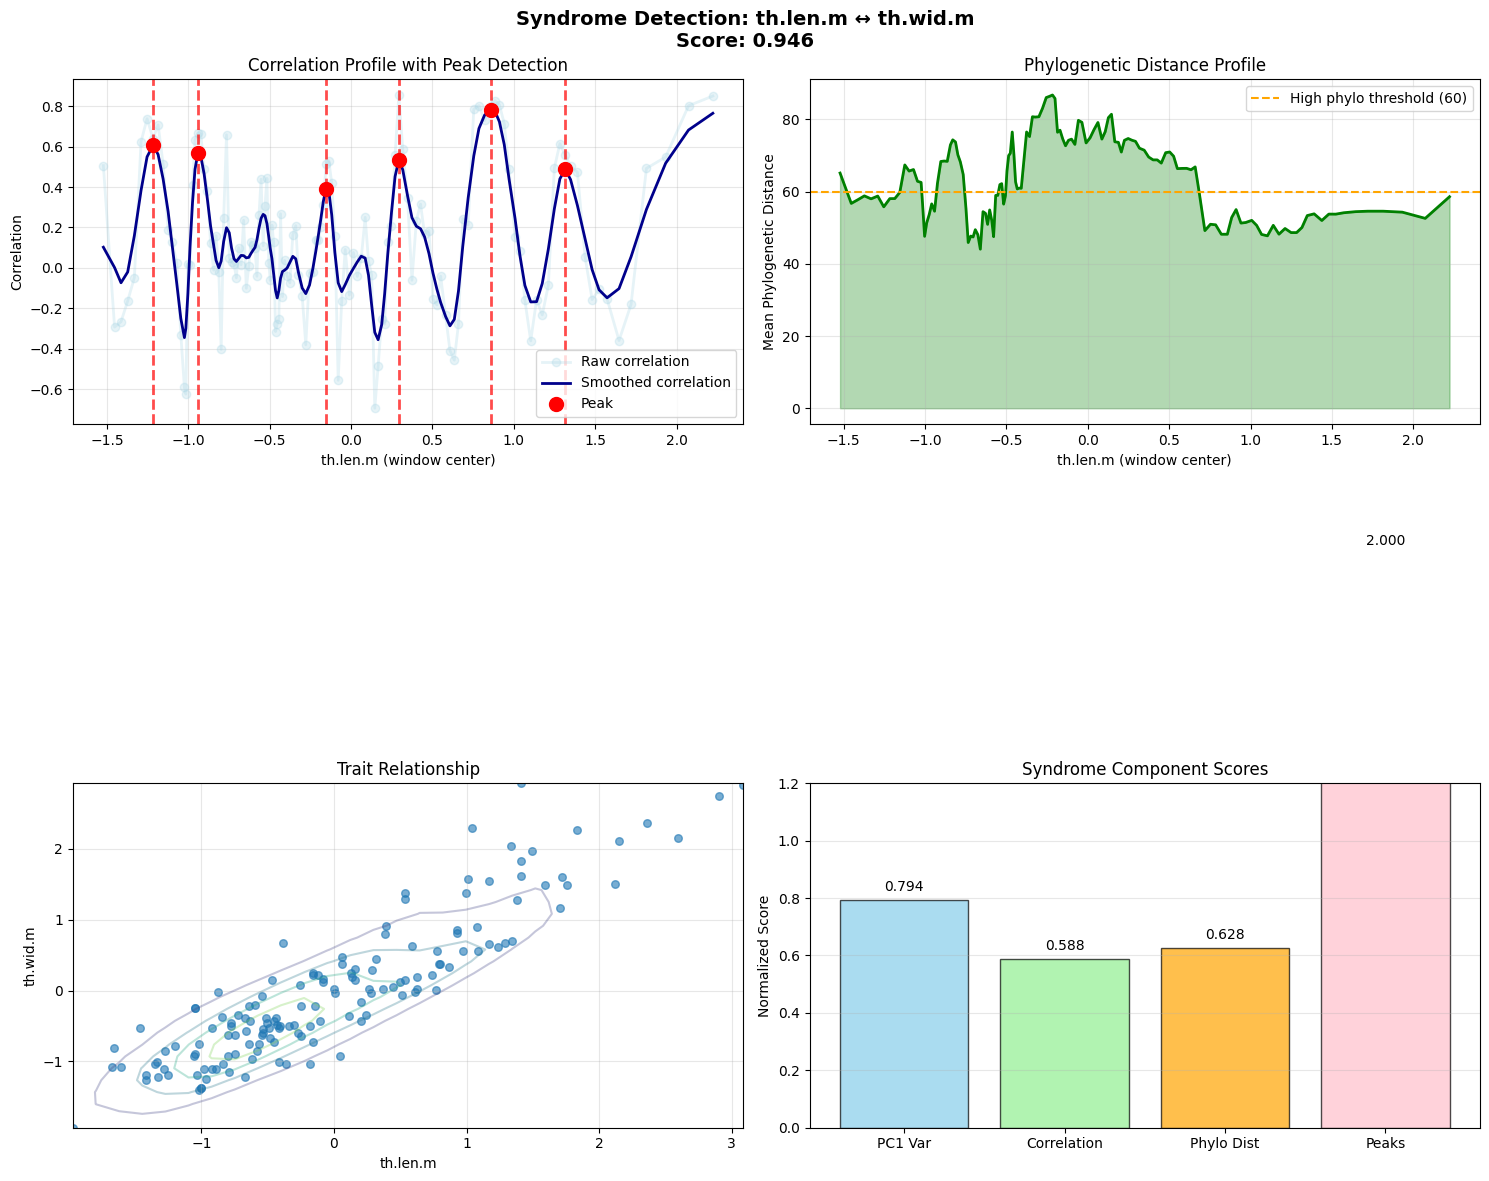

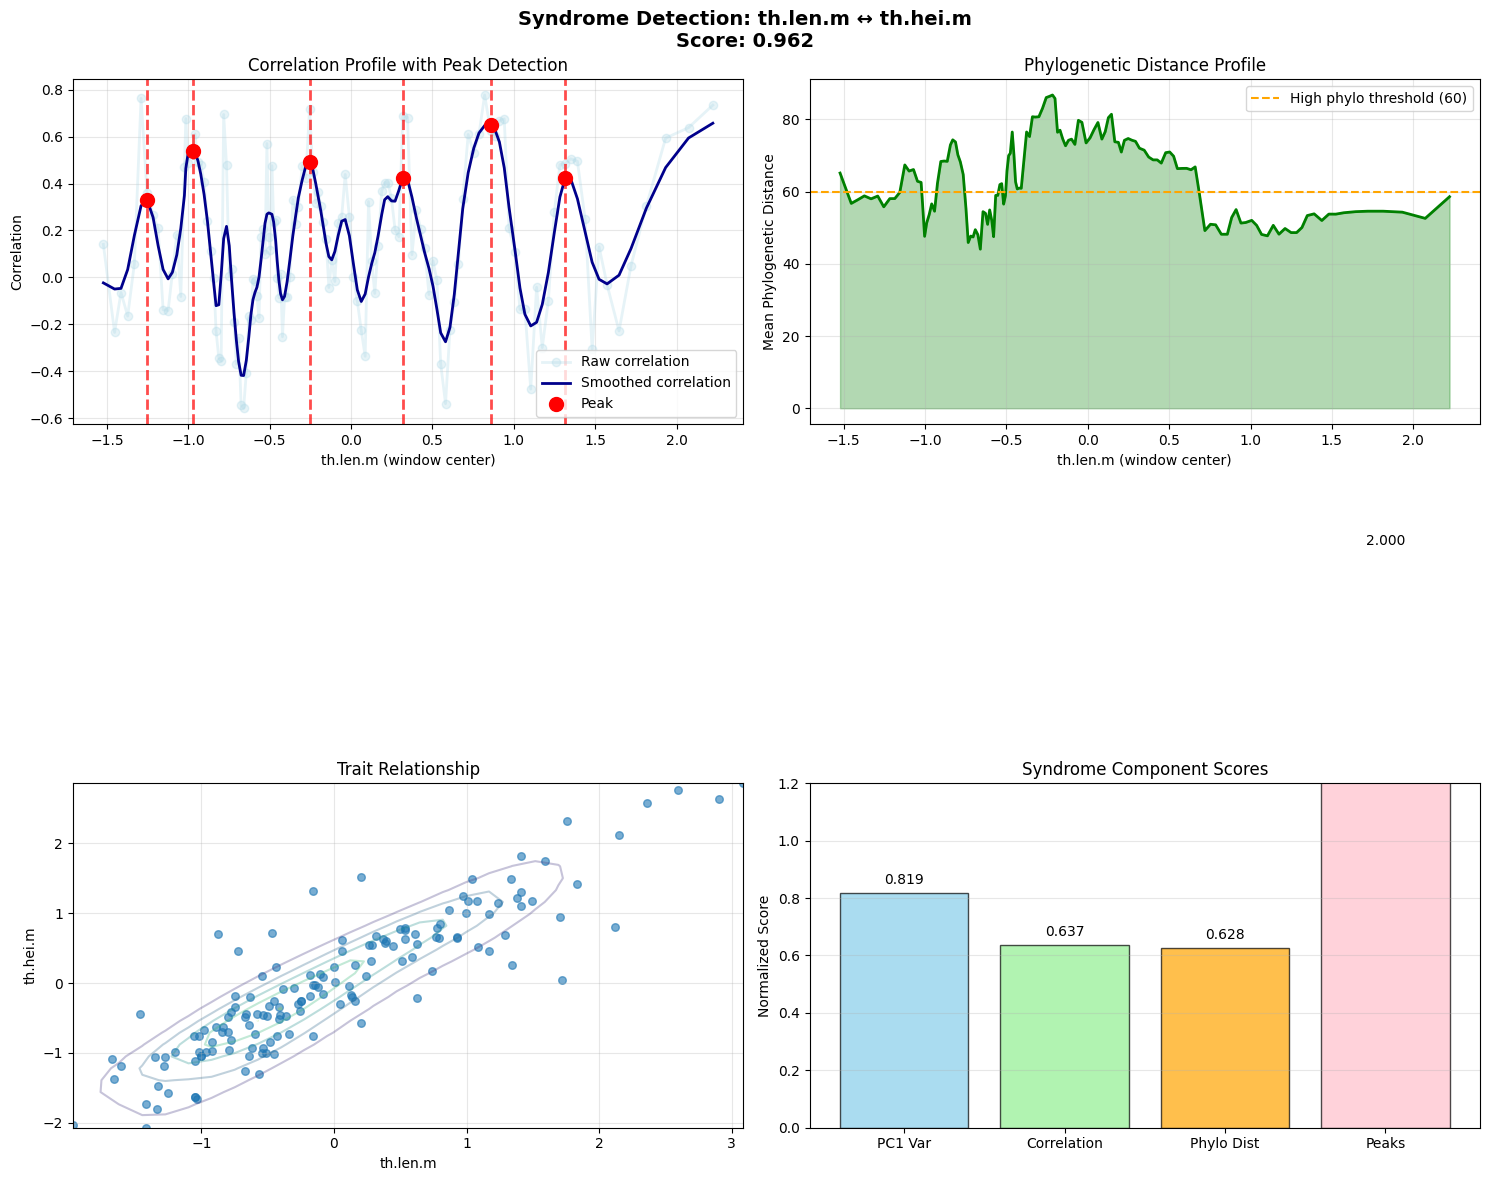

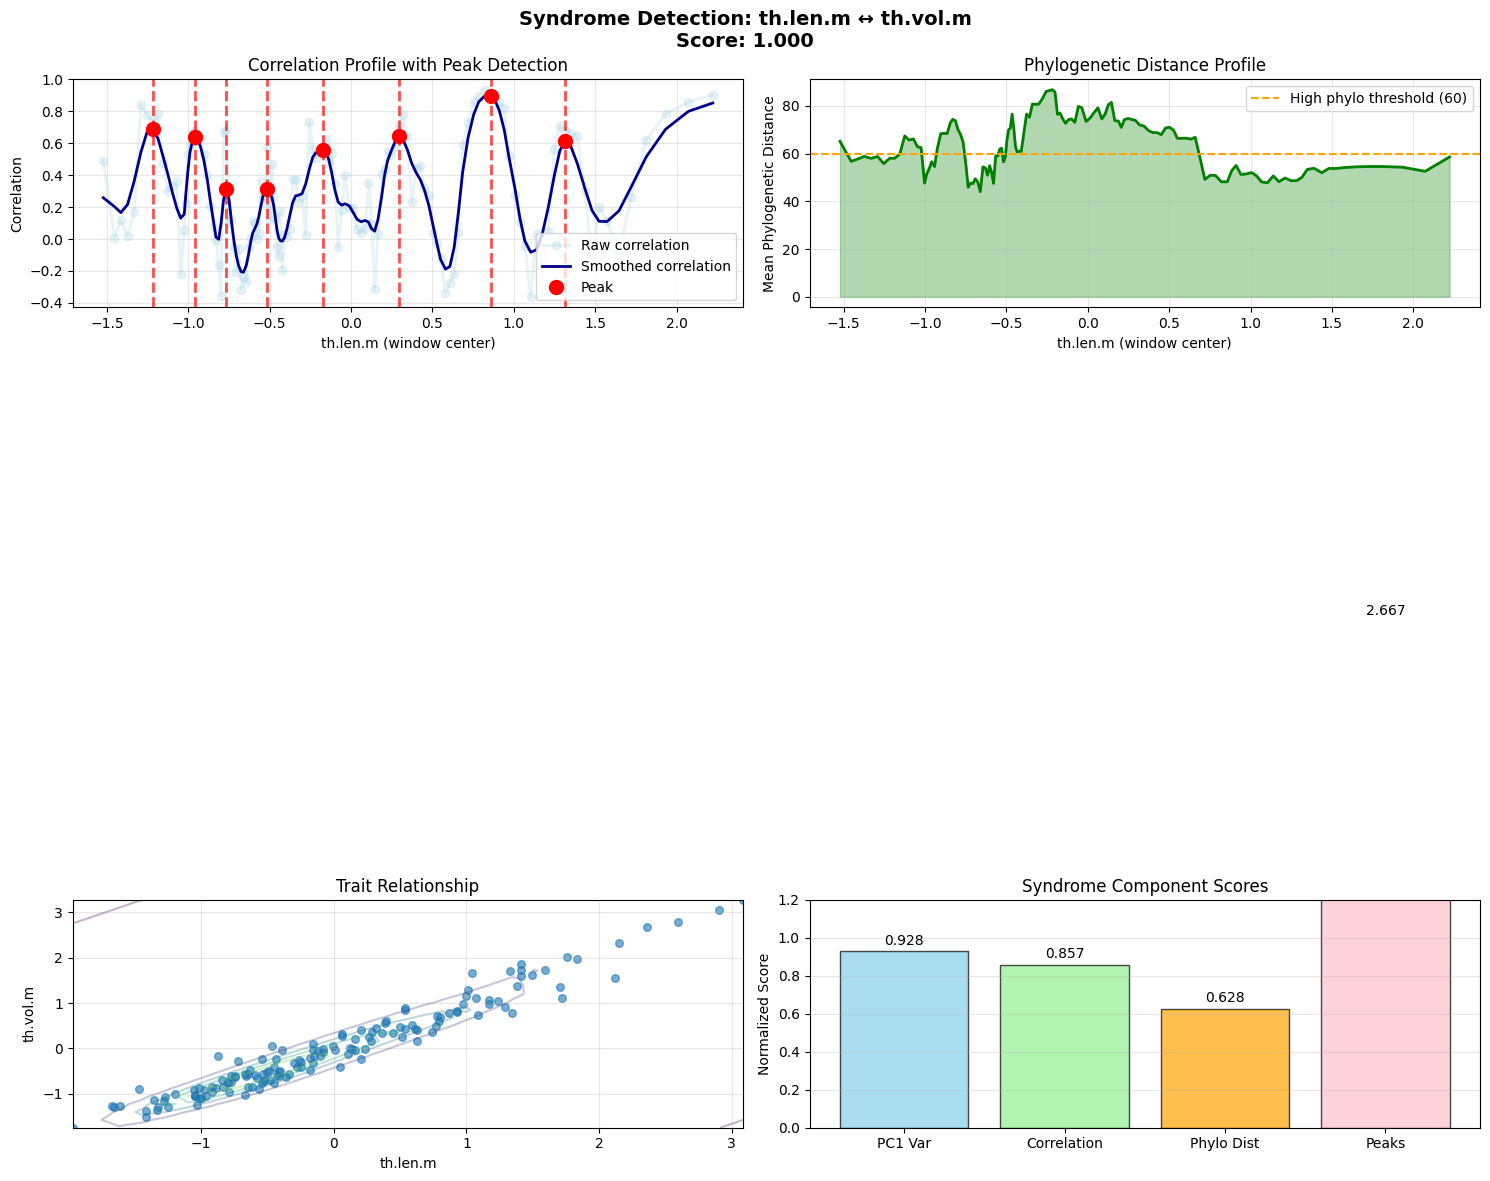

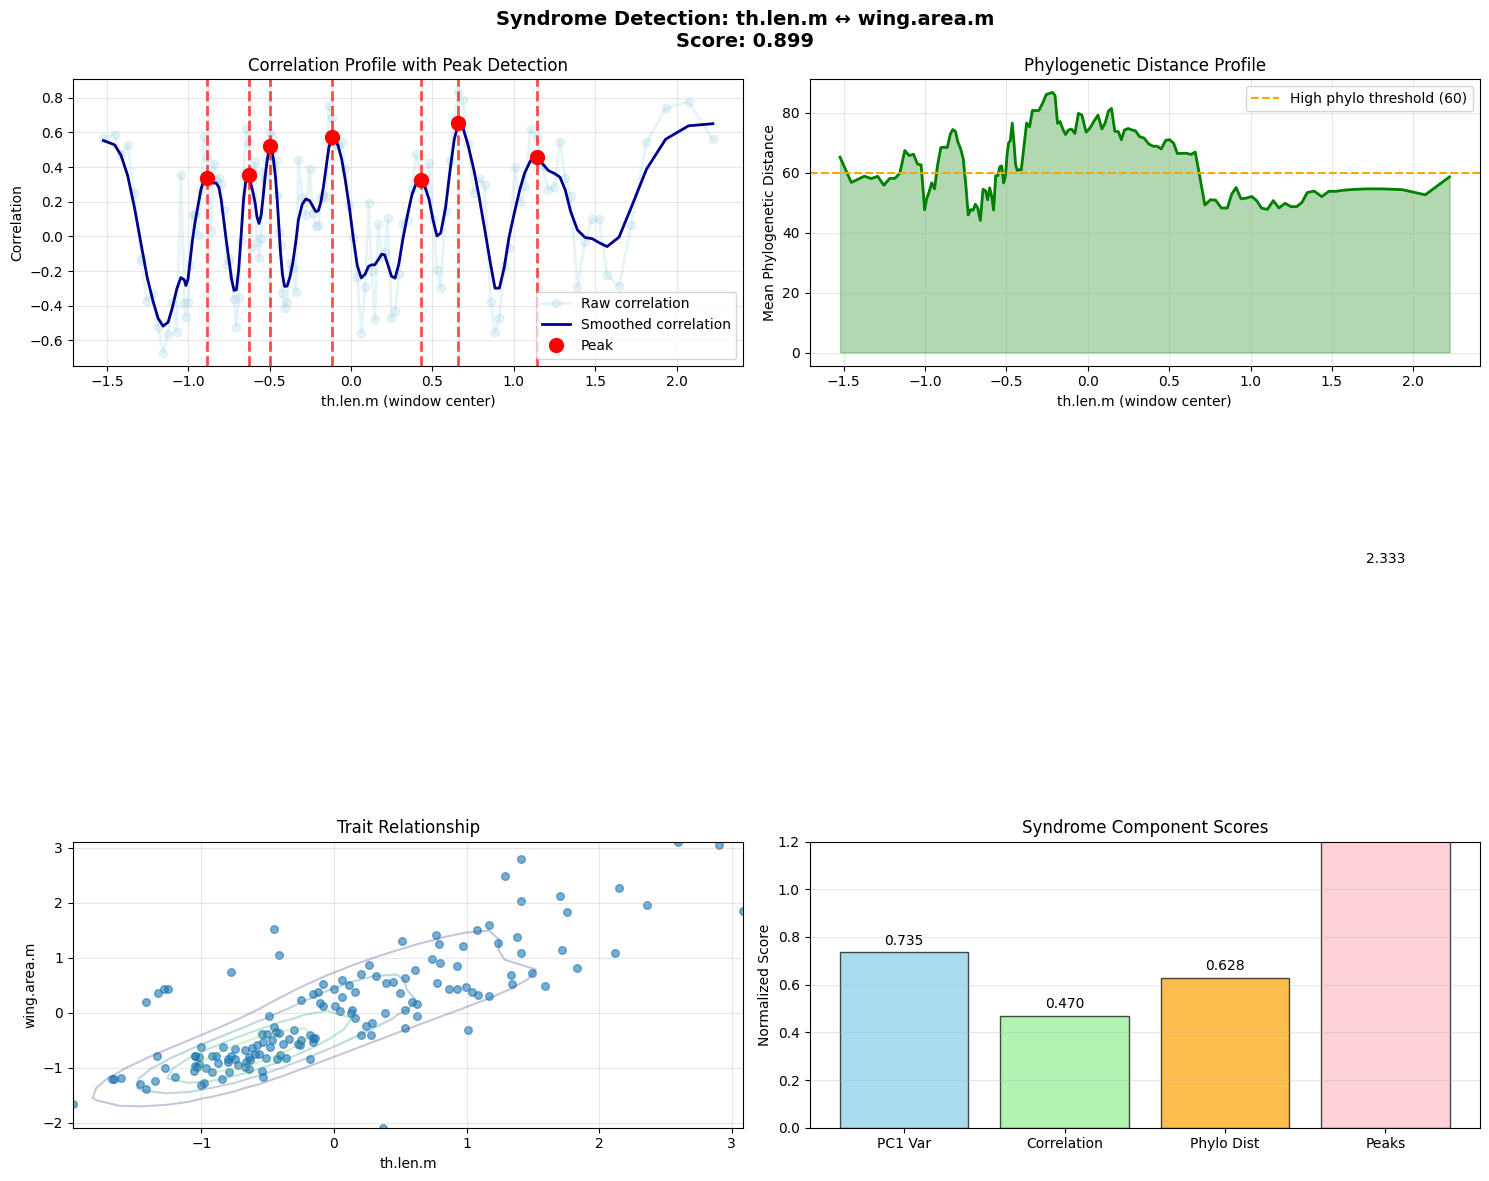

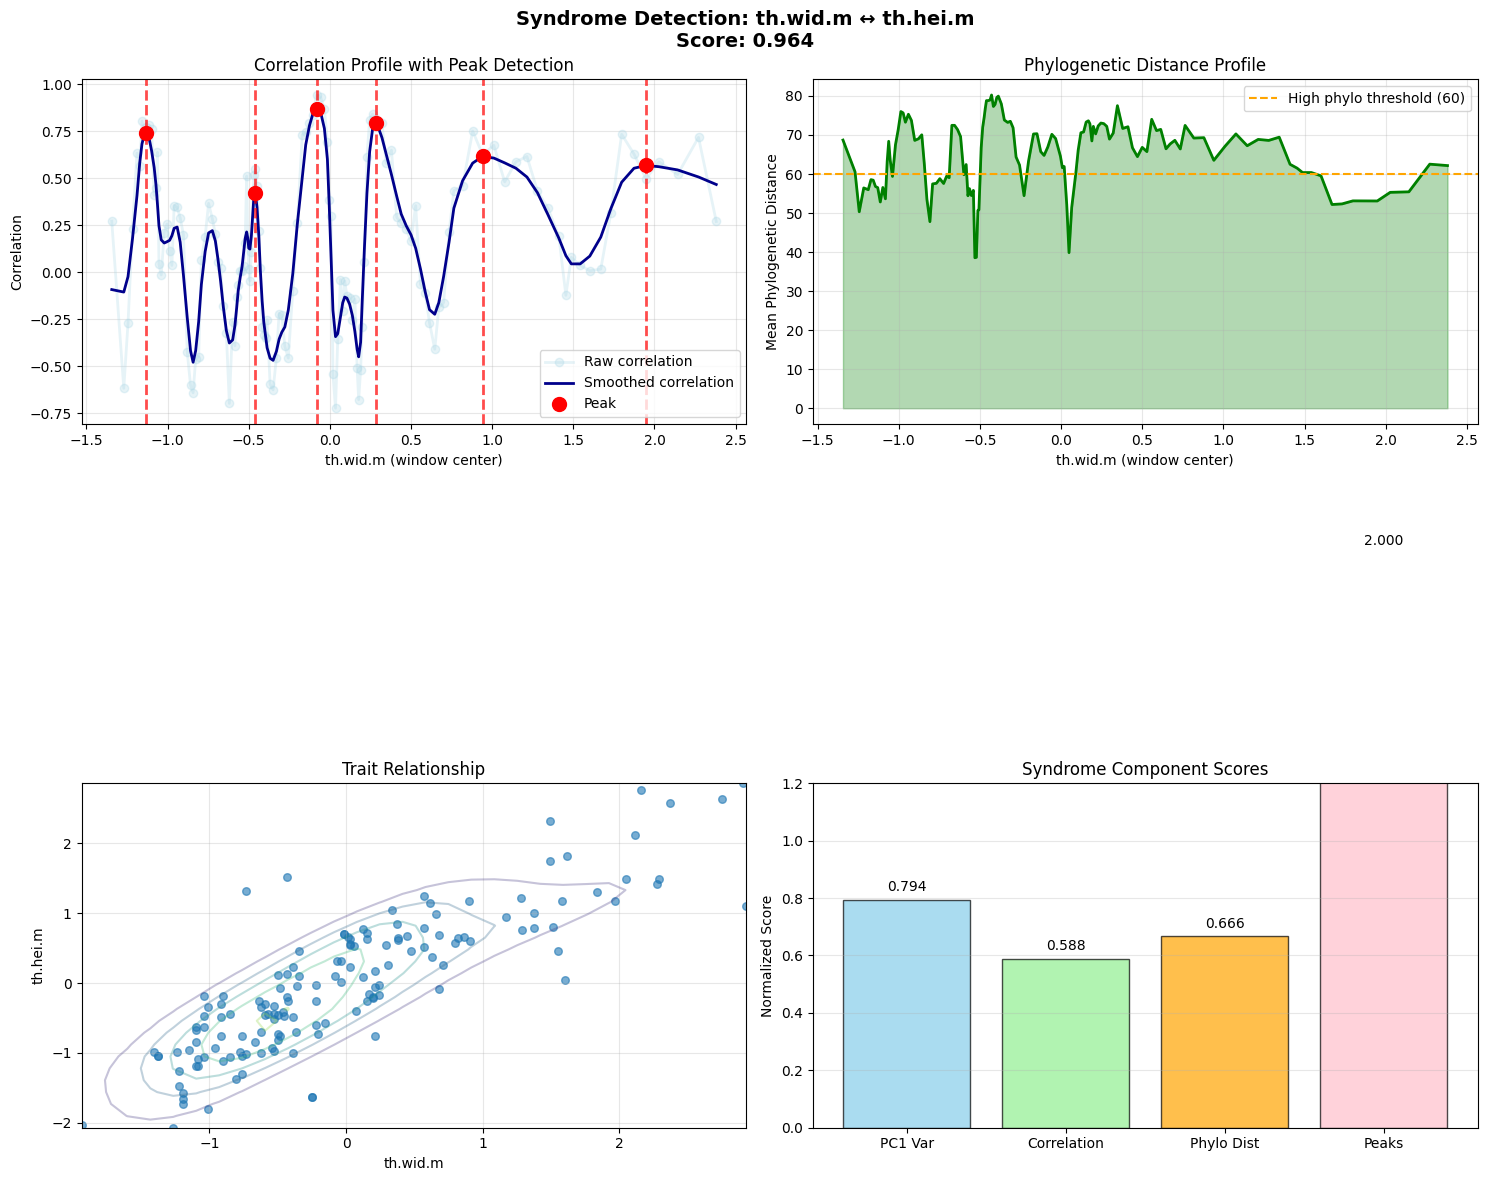

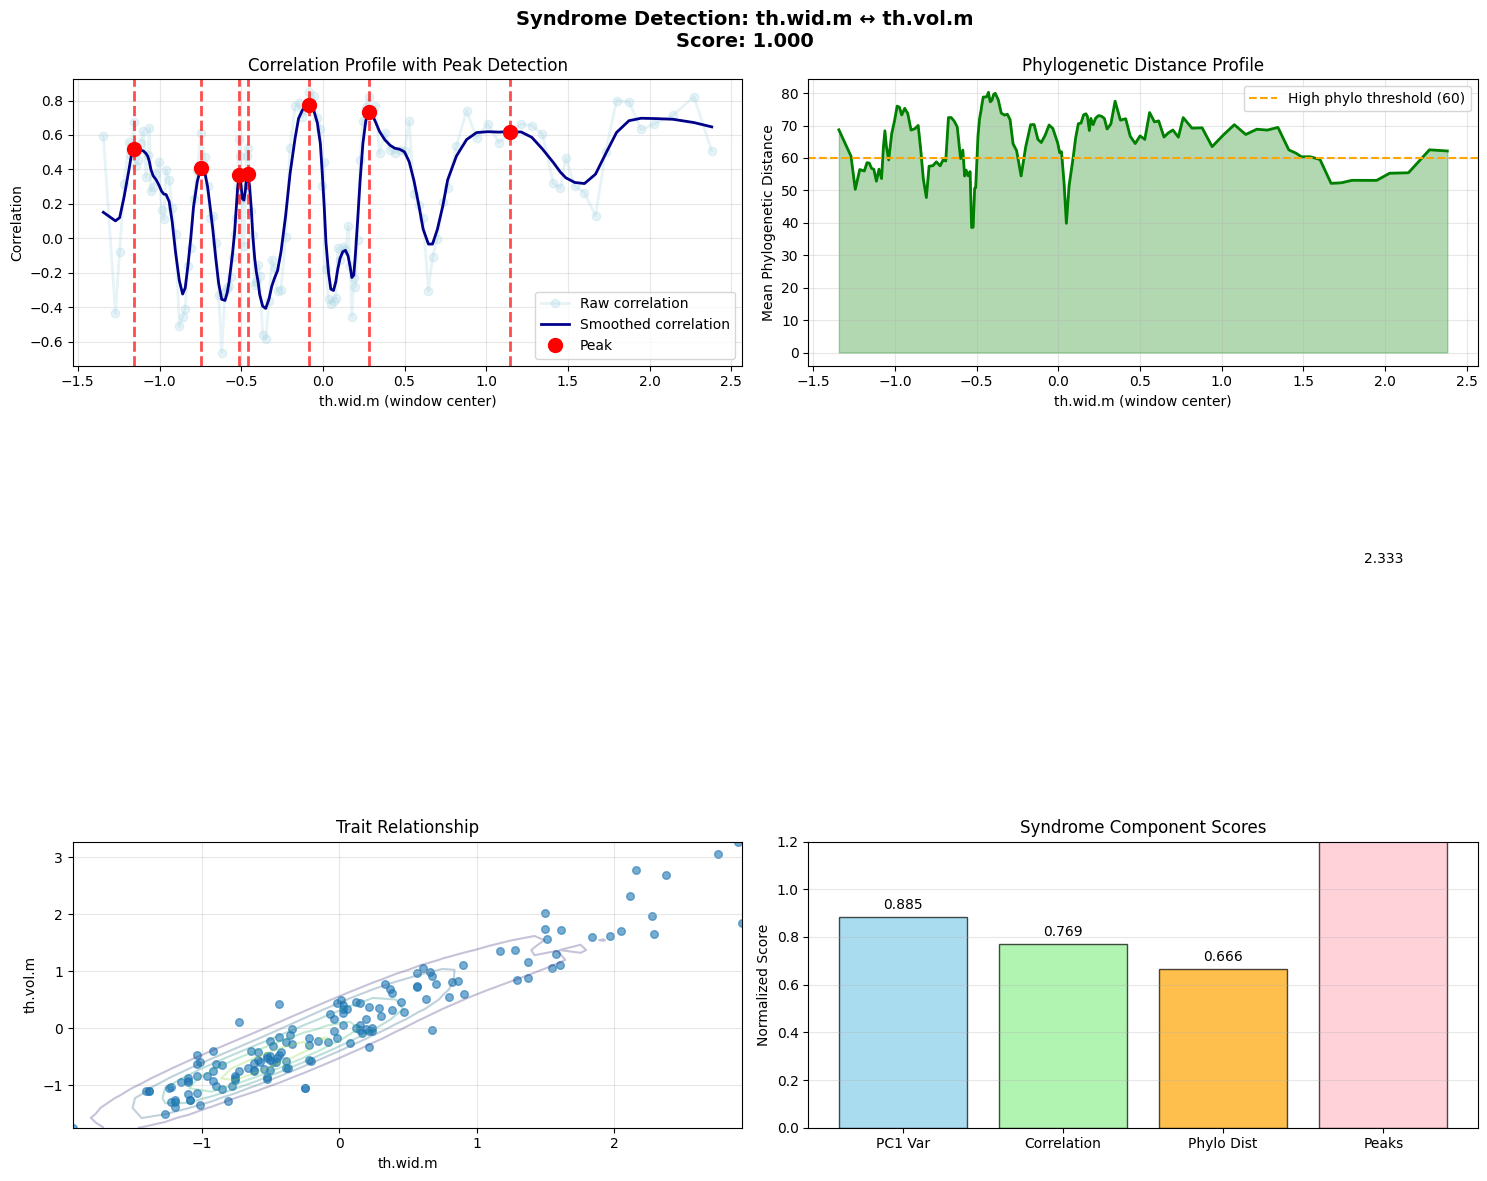

In [23]:


"""
This cell creates visualizations showing:
1. Density-based quantiles (clusters) for trait values
2. Correlation profile with Gaussian smoothing
3. Detected peaks (syndrome hotspots)
4. Phylogenetic distance profiles
"""

def visualize_syndrome_detection(trait_a, trait_b, result, trait_a_name, trait_b_name):
    """
    Create comprehensive visualization of syndrome detection results.
    """
    if not result or not result['correlation_profile']:
        print(f"No data to visualize for {trait_a_name} ↔ {trait_b_name}")
        return
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle(f'Syndrome Detection: {trait_a_name} ↔ {trait_b_name}\nScore: {result["syndrome_score"]:.3f}', 
                 fontsize=14, fontweight='bold')
    
    # Prepare data
    correlations = result['correlation_profile']
    window_centers = [c['window_center'] for c in correlations]
    raw_corrs = [c['correlation'] for c in correlations]
    phylo_dists = [c['phylo_distance'] for c in correlations]
    
    # Smooth correlations
    smoothed = gaussian_filter1d(np.array(raw_corrs), sigma=1.5)
    
    # Plot 1: Correlation profile with smoothing
    axes[0, 0].plot(window_centers, raw_corrs, 'o-', alpha=0.3, color='lightblue', 
                   label='Raw correlation', linewidth=2)
    axes[0, 0].plot(window_centers, smoothed, '-', color='darkblue', 
                    label='Smoothed correlation', linewidth=2)
    
    # Mark detected peaks
    if result['peak_details']:
        for peak in result['peak_details']:
            axes[0, 0].axvline(x=peak['window_center'], color='red', 
                             linestyle='--', alpha=0.7, linewidth=2)
            axes[0, 0].plot(peak['window_center'], peak['correlation'], 
                          'ro', markersize=10, label='Peak' if peak == result['peak_details'][0] else '')
    
    axes[0, 0].set_title('Correlation Profile with Peak Detection')
    axes[0, 0].set_xlabel(f'{trait_a_name} (window center)')
    axes[0, 0].set_ylabel('Correlation')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Plot 2: Phylogenetic distance profile
    axes[0, 1].plot(window_centers, phylo_dists, '-', color='green', linewidth=2)
    axes[0, 1].fill_between(window_centers, phylo_dists, alpha=0.3, color='green')
    axes[0, 1].set_title('Phylogenetic Distance Profile')
    axes[0, 1].set_xlabel(f'{trait_a_name} (window center)')
    axes[0, 1].set_ylabel('Mean Phylogenetic Distance')
    axes[0, 1].grid(True, alpha=0.3)
    
    # Highlight regions with high phylogenetic distance
    threshold = 60
    high_phylo_mask = np.array(phylo_dists) > threshold
    if np.any(high_phylo_mask):
        axes[0, 1].axhline(y=threshold, color='orange', linestyle='--', 
                          label=f'High phylo threshold ({threshold})')
        axes[0, 1].legend()
    
    # Plot 3: Scatter plot of trait relationship
    xy = np.column_stack([trait_a, trait_b])
    valid_mask = ~(np.isnan(xy).any(axis=1))
    xy_clean = xy[valid_mask]
    
    axes[1, 0].scatter(xy_clean[:, 0], xy_clean[:, 1], alpha=0.6, s=30)
    axes[1, 0].set_title('Trait Relationship')
    axes[1, 0].set_xlabel(trait_a_name)
    axes[1, 0].set_ylabel(trait_b_name)
    axes[1, 0].grid(True, alpha=0.3)
    
    # Add density contour
    try:
        from scipy.stats import gaussian_kde
        kde = gaussian_kde(xy_clean.T)
        x_range = np.linspace(xy_clean[:, 0].min(), xy_clean[:, 0].max(), 30)
        y_range = np.linspace(xy_clean[:, 1].min(), xy_clean[:, 1].max(), 30)
        X, Y = np.meshgrid(x_range, y_range)
        Z = kde(np.vstack([X.ravel(), Y.ravel()])).reshape(X.shape)
        axes[1, 0].contour(X, Y, Z, levels=5, alpha=0.3)
    except:
        pass
    
    # Plot 4: Summary metrics bar chart
    metrics = ['PC1 Var', 'Correlation', 'Phylo Dist', 'Peaks']
    values = [
        result['mean_pc1_variance'],
        result['mean_correlation'],
        result['mean_phylo_distance'] / 100,  # Normalize
        result['n_peaks'] / 3  # Normalize (3 peaks = 1.0)
    ]
    
    colors = ['skyblue', 'lightgreen', 'orange', 'pink']
    bars = axes[1, 1].bar(metrics, values, color=colors, alpha=0.7, edgecolor='black')
    axes[1, 1].set_title('Syndrome Component Scores')
    axes[1, 1].set_ylabel('Normalized Score')
    axes[1, 1].set_ylim(0, 1.2)
    axes[1, 1].grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for i, (bar, val) in enumerate(zip(bars, values)):
        height = bar.get_height()
        axes[1, 1].text(bar.get_x() + bar.get_width()/2., height + 0.02,
                       f'{val:.3f}',
                       ha='center', va='bottom', fontsize=10)
    
    plt.tight_layout()
    plt.show()

# Run visualization for top results if available
print("\n" + "=" * 60)
print("ADVANCED SYNDROME DETECTION - VISUALIZATION")
print("=" * 60)

# Check if we have results from previous test
if 'test_results' in globals() and len(test_results) > 0:
    print(f"\nVisualizing top {min(2, len(test_results))} results...")
    
    for i, result in enumerate(test_results[:6]):
        trait_a = trait_data_zscored[result['trait_a']].values
        trait_b = trait_data_zscored[result['trait_b']].values
        
        visualize_syndrome_detection(
            trait_a, trait_b, result,
            result['trait_a'], result['trait_b']
        )
else:
    print("\nRun the previous cell first to generate test results.")
    print("You can also run advanced_syndrome_detection() on any trait pair.")
